In [ ]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model
from keras.applications import VGG16
from keras.applications import Xception, InceptionV3
from keras.applications import ResNet50V2, ResNet152V2
from keras.applications import MobileNetV3Small, MobileNetV3Large

# Model training
from keras import Sequential
import keras
from tensorflow.keras.layers import Dense


# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# 전처리 파트 (수정 가능)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/utkface-new


In [ ]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 299    # Xception은 229 * 229

# 데이터셋 점검 (수정 가능)

Total number of images  : 23708
Sample Image path       : 1_0_3_20161220222642427.jpg.chip.jpg
Sample Age              : 1
Sample Gender           : Male



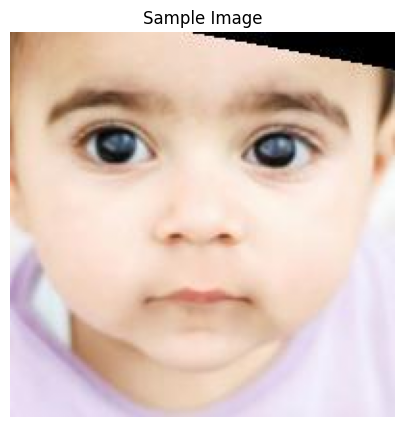

In [ ]:
# Initialize the directory path
dir_path = os.path.join(path, "UTKFace")
image_paths = os.listdir(dir_path)

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(os.path.join(dir_path, rand_image_path)) / 255.
sample_age, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

# 전처리 과정(파일 이름에서 라벨링, 수정 가능)

# 데이터셋 분할 (수정 가능)

In [ ]:
# 이미지 경로들을 무작위로 섞기 (재현 가능성 위해 시드 고정)
np.random.seed(42)
np.random.shuffle(image_paths)

# 1. 전체 데이터 → 학습/테스트 분할 (90% 학습용, 10% 테스트용)
train_valid_images, test_images = train_test_split(
    image_paths,
    train_size=0.9,
    test_size=0.1,
    random_state=42
)

# 2. 학습용 데이터 → 학습/검증 분할 (90% 학습용, 10% 검증용)
train_images, valid_images = train_test_split(
    train_valid_images,
    train_size=0.9,
    test_size=0.1,
    random_state=42
)

# 결과 확인
print(f"Training Size  : {len(train_images)}")
print(f"Validation Size: {len(valid_images)}")
print(f"Testing Size   : {len(test_images)}")

# 나이 라벨 추출 함수
def extract_labels(image_list):
    ages = [int(path.split("_")[0]) for path in image_list]
    return ages

# 학습, 검증, 테스트 데이터에 대해 라벨 추출
train_ages = extract_labels(train_images)
valid_ages = extract_labels(valid_images)
test_ages = extract_labels(test_images)

Training Size  : 19203
Validation Size: 2134
Testing Size   : 2371


# 전처리 과정 (이미지를 텐서 형태로 변환)

In [ ]:
def show_image(image, show=False):
    """
    이미지를 시각화하는 함수입니다. 축은 제거되고,
    show=True일 경우에만 실제로 plt.show()로 출력합니다.

    Args:
    - image (array-like): 표시할 이미지 배열
    - show (bool): True이면 이미지 출력 (기본값: False)

    Returns:
    - None
    """
    plt.imshow(image)       # 이미지 시각화
    plt.axis("off")         # x, y 축 숨김

    if show:
        plt.show()          # show=True인 경우에만 출력

# ------------------------------------------------------------

def preprocess_age_data(image_path, age, dir_path=dir_path, IMAGE_SIZE=IMAGE_SIZE):
    """
    나이(age) 예측을 위한 이미지 전처리 함수입니다.
    JPEG 이미지 파일을 로드하고 크기 조정 및 정규화를 수행한 후,
    나이 값을 함께 반환합니다.

    Args:
    - image_path (str): 이미지 파일 이름
    - age (int): 라벨로 사용할 나이 값
    - gender (int): (사용되지 않지만, 필요시 활용 가능)
    - dir_path (str): 이미지가 저장된 디렉토리 경로
    - IMAGE_SIZE (int): 리사이징할 이미지 크기 (정사각형)

    Returns:
    - tuple: (전처리된 이미지, 나이)
    """
    def _load_image(path):
        path = path.numpy().decode("utf-8")  # bytes -> str
        full_path = os.path.join(dir_path, path)
        image = tf.io.read_file(full_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = tf.cast(image, tf.float32) / 255.0
        return image

    image = tf.py_function(_load_image, [image_path], tf.float32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return image, age

# 데이터셋 구성 (batch size로 자르기, prefetch)

In [ ]:
# (이미지 경로, 나이)을 튜플로 묶어 TensorFlow Dataset으로 변환 후 셔플
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages)).shuffle(2000)

# 나이 예측용 데이터셋: 이미지 전처리 및 age 반환 → 배치 & prefetch로 성능 향상
train_age_ds = train_ds.map(
    preprocess_age_data,                         # 이미지 전처리 + 나이 추출
    num_parallel_calls=BATCH_SIZE                # 병렬처리로 속도 향상
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)      # 배치 및 prefetch

# ------------------------------
# Validation Dataset 구성
# ------------------------------

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages)).shuffle(2000)

valid_age_ds = valid_ds.map(
    preprocess_age_data,
    num_parallel_calls=BATCH_SIZE
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

# ------------------------------
# Testing Dataset 구성
# ------------------------------

test_ds = tfds.Dataset.from_tensor_slices((test_images, test_ages)).shuffle(500)

test_age_ds = test_ds.map(
    preprocess_age_data,
    num_parallel_calls=BATCH_SIZE
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

# 알맞은 형식으로 띄우기 (plt)

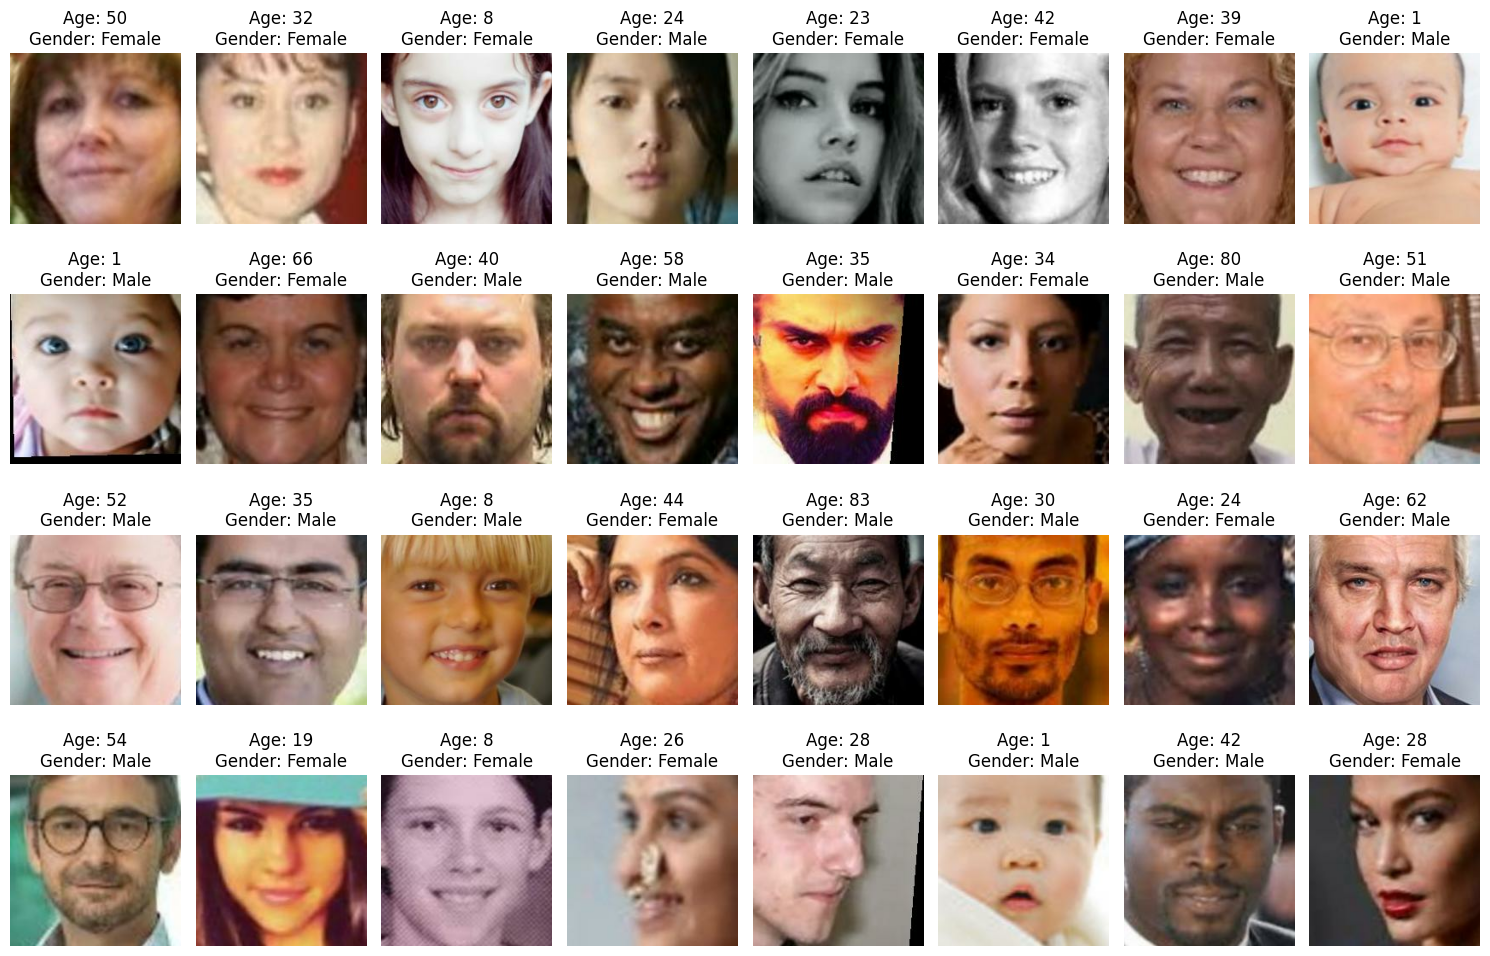

In [ ]:
# 이미지가 저장된 경로 (앞서 정의한 경로)
dir_path = "/kaggle/input/utkface-new/UTKFace/"

# 전체 이미지 플롯의 크기 설정 (가로 15인치, 세로 10인치)
plt.figure(figsize=(15, 10))

# train_ds에서 한 배치(BATCH_SIZE만큼)를 가져옴
for images, ages in train_ds.batch(BATCH_SIZE).take(1):

    # 해당 배치의 이미지 개수만큼 반복
    for index in range(len(images)):
        # 이미지 경로를 사용해 이미지 파일 로딩 및 디코딩
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)

        # 4행 8열 서브플롯에 이미지 시각화
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)

        # 이미지 상단에 나이 정보 표시
        plt.title(f"Age: {ages[index]}")

        # 축은 표시하지 않음
        plt.axis("off")

# 레이아웃 자동 정렬 (타이틀 겹침 방지)
plt.tight_layout()

# 플롯 출력
plt.show()

In [ ]:
# 다양한 사전 학습된 이미지 분류 백본 모델 초기화
# 각 모델은 ImageNet 데이터셋으로 사전 학습되었으며, 최상위 분류 층은 제거된 상태 (include_top=False)

backbones = [
    (
        "VGG16",  # 고전적인 CNN 구조, 파라미터가 많고 상대적으로 느림
        VGG16(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),  # 입력 이미지 크기 설정
            weights = "imagenet",                      # ImageNet으로 사전 학습된 가중치 사용
            include_top = False                        # 마지막 FC layer 제거 (커스터마이징 목적)
        )
    ),

    (
        "ResNet50V2",  # ResNet의 개선된 버전, 성능과 효율성 균형
        ResNet50V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "ResNet152V2",  # 더 깊은 ResNet, 더 많은 파라미터와 높은 표현력
        ResNet152V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "Xception",  # 깊이 분리 합성곱(Depthwise Separable Convolution)을 활용한 고성능 모델
        Xception(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "InceptionV3",  # 다양한 스케일의 특징을 학습할 수 있는 구조
        InceptionV3(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "MobileNetV3Small",  # 경량 모델, 모바일 환경에 적합, 성능은 다소 낮을 수 있음
        MobileNetV3Small(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "MobileNetV3Large",  # MobileNetV3Small보다 성능이 높은 경량 모델
        MobileNetV3Large(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),
]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 전이 학습 모델 선택
* VGG 이도현  
* ResNet 백지웅
* Alexnet 전형진
* Xception 배성범
* custom1 CNN 김태우
* custom2 CNN 이현석

In [ ]:
import os

def cls():
    os.system('cls' if os.name == 'nt' else 'clear')

나이 예측 모델 학습 결과 요약

1. MobileNet 계열 백본

- 성능이 일관되게 나빠서 이번 과제에 적합하지 않음.

- 명확히 제외 대상임.

2. VGG16 백본

- 가장 유망한 모델.

- 훈련 손실과 검증 손실이 꾸준히 감소하며 안정적으로 수렴함.

- 평균 절대 오차(MAE)가 약 8.0 근처에서 안정됨.

- 모델이 튼튼하고 일반화 성능이 좋음.

3. Inception, Xception 백본

- 훈련 손실은 낮지만, 훈련과 검증 손실 간 차이가 큼(과적합 가능성 있음).

- Inception은 Xception보다 학습 곡선이 더 부드럽고 예측 가능함.

- 속도와 안정성 면에서 Inception이 좋은 대안임.

# 주어진 모델 훈련 파트


In [ ]:
from tensorflow.keras import layers, Model, Input

# input_shape=(299, 299, 3)
def myXception(input):

    # Entry Flow

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same')(input) # (150, 150, 32)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x) # (150, 150, 64)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
 
    residual = layers.Conv2D(filters=128, kernel_size=(1, 1), strides=2, padding='same')(x) # Skip Connection, (75, 75, 128)

    x = layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same')(x)   # (150, 150, 128)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same')(x)  # (150, 150, 128)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)   # (75, 75, 128)
    x = layers.Add()([x, residual])

    residual = layers.Conv2D(filters=256, kernel_size=(1, 1), strides=2, padding='same')(x) # Skip Connection, (38, 38, 256)

    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same')(x)   # (75, 75, 256)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same')(x)  # (75, 75, 256)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)   # (38, 38, 256)
    x = layers.Add()([x, residual])

    residual = layers.Conv2D(filters=728, kernel_size=(1, 1), strides=2, padding='same')(x) # Skip Connection, (19, 19, 728)

    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same')(x)   # (38, 38, 728)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same')(x)  # (38, 38, 728)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)   # (19, 19, 728)
    x = layers.Add()([x, residual])

    # Middle Flow

    for i in range(8):
        residual = x # Skip Connection

        x = layers.ReLU()(x)
        x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same')(x)   # (19, 19, 728)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same')(x)   # (19, 19, 728)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same')(x)  # (19, 19, 728)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])

    # Exit Flow
    
    residual = layers.Conv2D(filters=1024, kernel_size=(1, 1), strides=2, padding='same')(x) # Skip Connection, (10, 10, 1024)

    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=728, kernel_size=(3, 3), padding='same')(x)   # (19, 19, 728)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=1024, kernel_size=(3, 3), padding='same')(x) # (19, 19, 1024)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)   # (10, 10, 1024)
    x = layers.Add()([x, residual])

    x = layers.SeparableConv2D(filters=1536, kernel_size=(3, 3), padding='same')(x)  # (10, 10, 1536)
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=2048, kernel_size=(3, 3), padding='same')(x)  # (10, 10, 2048)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)  # (2048, )

    return x

In [ ]:
# 1. 입력 정의
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))  # 예: (299, 299, 3)

# 2. Feature extractor: 사용자 정의 Xception
x = myXception(input_tensor)

# 3. 출력층 (나이 회귀: 실수 값 하나 출력)
output = Dense(1, activation='linear')(x)

# 4. 모델 정의
age_net = Model(inputs=input_tensor, outputs=output)

# 5. 컴파일
age_net.compile(
    optimizer='adam',
    loss='mse',           # 회귀 문제: 평균 제곱 오차
    metrics=['mae']       # 보조 지표로 MAE
)

In [ ]:
# 나이 예측 모델 학습 시작
age_history = age_net.fit(
    train_age_ds,                 # 학습용 데이터셋
    validation_data=valid_age_ds, # 검증용 데이터셋
    epochs=10,                   # 최대 10 에폭까지 학습
    batch_size=BATCH_SIZE,       # 배치 크기 (사용자 지정 상수)
    callbacks=[                  # 학습 도중 호출되는 콜백 함수 목록
        EarlyStopping(
            patience=5,               # 검증 손실이 5번 연속 개선되지 않으면 학습 중단
            monitor="val_loss",      # 검증 손실(val_loss)을 모니터링
            restore_best_weights=True # 최적의 가중치로 복원
        ),
        ModelCheckpoint(
            "Age-VGG16.keras",     # 최적 모델 저장 파일명
            save_best_only=True    # 가장 성능 좋은 모델만 저장
        )
    ]
)

Epoch 1/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 242s 370ms/step - loss: 11.2733 - val_loss: 9.0540
Epoch 2/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 194s 287ms/step - loss: 8.2440 - val_loss: 10.1709
Epoch 3/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 206s 294ms/step - loss: 7.7549 - val_loss: 7.2444
Epoch 4/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 198s 287ms/step - loss: 7.2770 - val_loss: 7.2155
Epoch 5/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 171s 285ms/step - loss: 6.9678 - val_loss: 7.4670
Epoch 6/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 176s 293ms/step - loss: 6.8316 - val_loss: 6.9889
Epoch 7/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 175s 292ms/step - loss: 6.7192 - val_loss: 7.4608
Epoch 8/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 198s 285ms/step - loss: 6.4778 - val_loss: 7.0081
Epoch 9/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 202s 285ms/step - loss: 6.4873 - val_loss: 7.3168
Epoch 10/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 203s 287ms/step - loss: 6.3820 - val_loss: 6.9208
Epoch 11/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 175s 291ms/step - loss: 6.1833 - val_loss: 6.8554
Epoch 